## 06 预训练词向量及其应用

在 `05Implement.ipynb` 中，我们构建了几种机器学习模型，并通过训练、验证与测试，完成了文本情感分类问题。

通过观察实现的神经网络框架，包括 MLP、CNN、LSTM 以及 Transformer，可以看到其中都包括一个必不可少的组成部分——词向量层（Embedding Layer）。

回顾一下，词向量层的主要作用是将离散的词元映射到连续的向量空间中，从而使得模型能够更好地捕捉词与词之间的语义关系。

一般来说，词向量表示中的向量值是随着目标任务的优化过程自动调整的，即将词向量中的向量值看做模型的参数。

在 `05Implement.ipynb` 的实现中，我们使用了随机初始化的词向量，这意味着词向量的初始值是随机生成的，然后在训练过程中根据任务的损失函数进行调整。

这意味着，词向量在训练开始时并没有任何语义信息，而是通过大量的训练数据逐渐学习到词与词之间的关系。这种方法虽然有效，但无疑需要大量的训练数据和时间。

于是，我们引入了预训练词向量（Pre-trained Word Embeddings）的概念。预训练词向量是指在大规模语料库上预先训练好的词向量表示，这些词向量已经捕捉了丰富的语义信息。

通过使用预训练词向量，我们可以在特定任务上获得更好的性能，尤其是在训练数据有限的情况下。

按照词向量表示与上下文的相关性，预训练词向量可以分为两大类：

1. **静态词向量（Static Word Embeddings）**：每个词元对应一个固定的向量表示，独立于上下文。常用的静态词向量模型包括 Word2Vec、GloVe 和 FastText 等。

2. **动态词向量（Dynamic Word Embeddings）**：词元的向量表示会根据其在句子中的上下文而变化。常用的动态词向量模型包括 ELMo 等。

为了更形象地理解二者的区别，我们看下面这个例子：

> 句子 1：他 亲自 <u>下场</u> 参加 比赛

> 句子 2：竟 落得 这样 的 <u>下场</u>

显然，句子 1 和句子 2 中共同出现的“<u>下场</u>”一词的词义截然不同，并且具有不同的词性。

在静态词向量模型中，“<u>下场</u>”一词无论出现在句子 1 还是句子 2 中，其对应的词向量表示都是相同的，因为静态词向量不考虑上下文信息；

而对于动态词向量模型而言，“<u>下场</u>”一词的词向量表示会根据其所在句子的上下文而变化，从而针对两种不同的语境，得到两个不同的词向量表示，提高了模型对词义的理解能力。

关于两种预训练词向量的模型构建与训练方法，并不是本项目的重点内容。感兴趣的读者可以参考相关文献和教程进行深入学习。

在本 Notebook 中，我们主要应用静态词向量作为初始化的模型参数，将其集成到深度学习模型中，并在下游任务（即文本情感分类任务）中进行微调（Fine-tuning）。

### 导入模块并加载数据

无论使用预训练词向量与否，对模型的训练、验证与测试流程都是相同的。因此，我们可以直接复用 `05Implement.ipynb` 中的通用代码，以及各类模型的定义和相关代码。

然后，加载数据和词汇表。

In [ ]:
from pandas import DataFrame
import torch.nn as nn

from torch.utils.data import DataLoader

from MyModule import (
    load_data, 
    load_vocab, 
    class_weights, 
    train_model_with_validation, 
    test_model_comprehensive, 
    plot_training_curves,
    print_training_summary,
    save_training_results,
    BowDataset, 
)


train_data = load_data("data/train_tokenized_final.txt", sep=",", is_tokenized=True)
val_data = load_data("data/val_tokenized_final.txt", sep=",", is_tokenized=True)
test_data = load_data("data/test_tokenized_final.txt", sep=",", is_tokenized=True)

# 加载数据
train_dataset = BowDataset(train_data)
val_dataset = BowDataset(val_data)
test_dataset = BowDataset(test_data)

vocab = load_vocab("data/vocab_final.txt")

e:\anaconda3\envs\nlpllma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 构建预训练词向量矩阵

网络上有许多公开的预训练词向量资源可供下载和使用。这里，我们使用腾讯 AI Lab 提供的中文预训练词向量。

腾讯 AI Lab 预训练词向量采用文本文件格式存储，可以从以下链接下载获取：

腾讯 AI Lab 中文词向量的原版有约1200万个中文词汇和短语，词向量的维度为200维，文本文件总大小约15 GB。

我们使用其缩小版本，文本文件大小约190 MB，其中包含约10万个常用中文词汇和短语，词向量的维度仍为200维。

可以从以下链接下载该缩小版本以及其他大小版本的预训练词向量文件：https://github.com/cliuxinxin/TX-WORD2VEC-SMALL

这里已经事先将预训练词向量文件下载至本地，见本项目目录下 `./resources/Word2Vec-100000-small.txt`。

打开预训练词向量文件后，可以看到如下内容：

可以看到，预训练词向量的基本格式是：
- 每一行表示一个词元及其对应的词向量表示；
- 每一行的第一个元素是词元，后续的元素是该词元对应的词向量表示，各个词向量值之间以空格分隔。每个词向量的维度为200维。

据此，我们可以编写代码，读入预训练词向量。

那么，如何将得到的预训练词向量集成到深度学习模型中呢？

首先，我们需要构建一个预训练词向量矩阵。方法如下：
- 随机初始化一个形状为 `(vocab_size, embedding_dim)` 的矩阵 `embeddings`，其中 `vocab_size` 是词汇表的大小，`embedding_dim` 是词向量的维度
- 遍历预训练词向量文件中的每一行，提取词元和对应的词向量表示
- 如果词元在词汇表中存在，则用该词元对应的词向量表示替换到 `embeddings` 矩阵中对应的行

这样，当预训练词向量文件遍历结束后，`embeddings` 矩阵就包含了词汇表中所有词元的词向量表示，其中未在预训练词向量文件中出现的词元仍然保持随机初始化的向量表示。

In [ ]:
import numpy as np
import torch

def load_pretrained_embeddings(embedding_path, vocab, embedding_dim=200):
    """根据已有 vocab 构建向量矩阵"""
    embeddings = np.random.normal(scale=0.6, size=(len(vocab), embedding_dim))  # 随机初始化
    with open(embedding_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype='float32')
            if word in vocab.token_to_idx:
                embeddings[vocab[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float32)

embedding_matrix = load_pretrained_embeddings("resources/Word2Vec-100000-small.txt", vocab, embedding_dim=200)

获得词向量矩阵 `embedding_matrix` 后，如何将其集成到模型中呢？

方法很简单，只需要将 `embedding_matrix` 矩阵作为参数传递给模型类的 `from_pretrained()` 方法即可。

例如，可以按如下方式将其集成到 MLP 模型中：

```python
class MLP(nn.Module):
    def __init__(self, vocab_size, ..., 
                 pretrained_embedding_matrix=None, freeze=True):
        super(MLP, self).__init__()

        # EmbeddingBag 层
        self.embeddingbag = nn.EmbeddingBag.from_pretrained(
            pretrained_embedding_matrix, 
            freeze=freeze
            )

        # 线性变换：词向量层 -> 隐含层
        self.linear1 = nn.Linear(...)
```

注意到 `from_pretrained()` 方法中还有一个 `freeze` 参数，用于指定是否在训练过程中冻结词向量层的参数。

- 如果 `freeze=True`，则表示在训练过程中不更新词向量层的参数，即保持预训练词向量不变；

- 如果 `freeze=False`，则表示在训练过程中允许更新词向量层的参数，从而使模型能够根据特定任务的需求对词向量进行微调。

这里，我们将 `freeze` 参数设置为 `False`，以便在文本情感分类任务中对预训练词向量进行微调，从而提升模型的性能。

另外，还有很重要的一点。

我们设置了 `freeze=False`，这意味着训练过程中允许更新词向量层的参数，即词向量矩阵会在模型训练过程中发生变化。

因此，在构造模型时，不能直接将 `embedding_matrix` 传递给 `from_pretrained()` 方法，而应该传入 `embedding_matrix.clone().detach()`，其中：
- `clone()` 方法用于创建 `embedding_matrix` 的一个副本，确保在训练过程中对词向量矩阵的修改不会影响原始矩阵。
- `detach()` 方法用于将该副本从计算图中分离出来，防止梯度回传到原始矩阵，从而避免对原始矩阵的影响。

至此，预训练词向量矩阵的构建方法及集成于模型的方法就全部介绍完毕了。

接下来就是将预训练词向量集成到各类模型中，并在文本情感分类任务中进行训练与测试。

除多传入了 预训练词向量矩阵参数外，其余代码均与 `05Implement.ipynb` 中的实现相同，因此不再用文字赘述。

### 多层感知机

In [3]:
from MyModule import MLP, collate_fn_mlp

# 超参数设置
embedding_dim = 200
num_class = 3
hidden_dim = 256
batch_size = 32
num_epoch = 10


train_data_loader_mlp = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=True)
val_data_loader_mlp = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=False)
test_data_loader_mlp = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_mlp, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_pre_emb = MLP(len(vocab), embedding_dim, hidden_dim, num_class, 
                  embedding_matrix.clone().detach(), freeze=False)
mlp_pre_emb.to(device)

MLP(
  (embeddingbag): EmbeddingBag(35272, 200, mode='mean')
  (linear1): Linear(in_features=200, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [4]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(mlp_pre_emb.parameters(), lr=0.001)

mlp_history = train_model_with_validation(
    model=mlp_pre_emb,
    train_loader=train_data_loader_mlp,
    val_loader=val_data_loader_mlp,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)


Training Epoch 1: 100%|██████████| 8532/8532 [00:36<00:00, 236.44it/s]


Epoch 1/10
    Train Loss: 0.6442	Train Accuracy: 0.7107
    Valid Loss: 0.5899	Valid Accuracy: 0.7398
    Valid Precision: 0.7408	Valid Recall: 0.7398	Valid F1: 0.7371
    ✓ New best validation loss: 0.5899
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8532/8532 [00:34<00:00, 246.73it/s]


Epoch 2/10
    Train Loss: 0.5421	Train Accuracy: 0.7642
    Valid Loss: 0.5813	Valid Accuracy: 0.7454
    Valid Precision: 0.7446	Valid Recall: 0.7454	Valid F1: 0.7428
    ✓ New best validation loss: 0.5813
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8532/8532 [00:34<00:00, 246.40it/s]


Epoch 3/10
    Train Loss: 0.4932	Train Accuracy: 0.7870
    Valid Loss: 0.5876	Valid Accuracy: 0.7418
    Valid Precision: 0.7453	Valid Recall: 0.7418	Valid F1: 0.7345
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8532/8532 [00:34<00:00, 247.68it/s]


Epoch 4/10
    Train Loss: 0.4540	Train Accuracy: 0.8053
    Valid Loss: 0.6040	Valid Accuracy: 0.7490
    Valid Precision: 0.7474	Valid Recall: 0.7490	Valid F1: 0.7451
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8532/8532 [00:34<00:00, 246.82it/s]


Epoch 5/10
    Train Loss: 0.4216	Train Accuracy: 0.8210
    Valid Loss: 0.6287	Valid Accuracy: 0.7507
    Valid Precision: 0.7486	Valid Recall: 0.7507	Valid F1: 0.7467
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5813


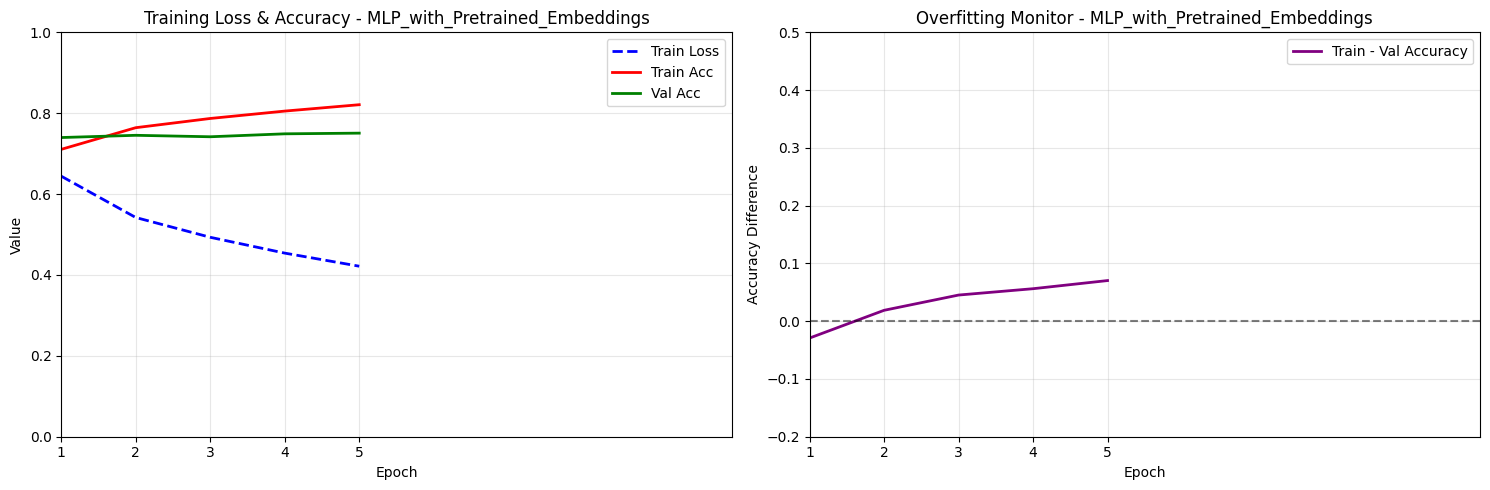


TRAINING SUMMARY
Model Name: MLP_with_Pretrained_Embeddings
Final Train Loss: 0.4216
Final Train Accuracy: 0.8210
Final Val Loss: 0.6287
Final Val Accuracy: 0.7507
Best Val Accuracy: 0.7507 (Epoch 5)
Final Overfitting Gap: 0.0703


In [5]:
# 绘制训练曲线
plot_training_curves("MLP_with_Pretrained_Embeddings", mlp_history)

# 打印训练摘要
print_training_summary("MLP_with_Pretrained_Embeddings", mlp_history)

Testing: 100%|██████████| 58497/58497 [00:45<00:00, 1279.26it/s]



TEST RESULTS
Model Name: MLP_with_pretrained_embeddings
Test Accuracy: 0.7437
Test Precision (weighted): 0.7424
Test Recall (weighted): 0.7437
Test F1 Score (weighted): 0.7411

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7915    0.7274    0.7581     18605
     Neutral     0.6628    0.5956    0.6274     14749
    Positive     0.7529    0.8427    0.7953     25143

    accuracy                         0.7437     58497
   macro avg     0.7357    0.7219    0.7269     58497
weighted avg     0.7424    0.7437    0.7411     58497



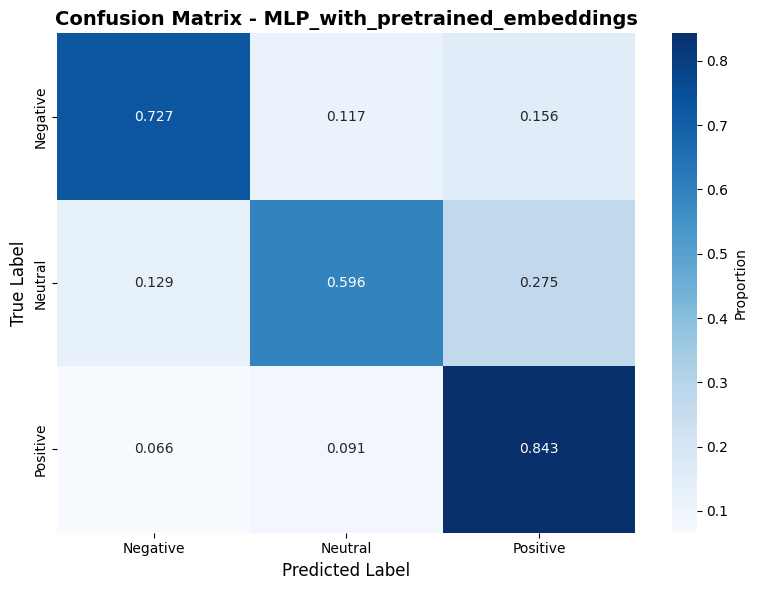


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7915, Recall=0.7274, F1=0.7581, Support=18605
 Neutral: Precision=0.6628, Recall=0.5956, F1=0.6274, Support=14749
Positive: Precision=0.7529, Recall=0.8427, F1=0.7953, Support=25143


In [6]:
mlp_test_results = test_model_comprehensive(
    model=mlp_pre_emb,
    model_name="MLP_with_pretrained_embeddings",
    test_loader=test_data_loader_mlp,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive']
)

In [7]:
# 保存MLP训练结果
save_training_results(
    model=mlp_pre_emb,
    model_name="MLP with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(mlp_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=mlp_history,
    test_results=mlp_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: MLP with Pretrained Embeddings (MLP)
  - 实际训练轮数: 5
  - 测试准确率: 0.7437
  - 测试F1分数: 0.7411
  - 记录时间: 2025-11-18 13:49:06
  - 总记录数: 36


### 卷积神经网络

In [8]:
from MyModule import CNN, collate_fn_cnn

train_data_loader_cnn = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=True)
val_data_loader_cnn = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=False)
test_data_loader_cnn = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_cnn, shuffle=False)

# CNN 相关参数
filter_size = 3
num_filter = 100

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_pre_emb = CNN(len(vocab), embedding_dim, filter_size, num_filter, num_class, 
                  embedding_matrix.clone().detach(), freeze=False)
cnn_pre_emb.to(device)

CNN(
  (embedding): Embedding(35272, 200)
  (conv1d): Conv1d(200, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)

In [9]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(cnn_pre_emb.parameters(), lr=0.001)

cnn_history = train_model_with_validation(
    model=cnn_pre_emb,
    train_loader=train_data_loader_cnn,
    val_loader=val_data_loader_cnn,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 8532/8532 [00:36<00:00, 231.95it/s]


Epoch 1/10
    Train Loss: 0.6108	Train Accuracy: 0.7257
    Valid Loss: 0.6051	Valid Accuracy: 0.7536
    Valid Precision: 0.7520	Valid Recall: 0.7536	Valid F1: 0.7507
    ✓ New best validation loss: 0.6051
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8532/8532 [00:36<00:00, 235.44it/s]


Epoch 2/10
    Train Loss: 0.5214	Train Accuracy: 0.7732
    Valid Loss: 0.6102	Valid Accuracy: 0.7576
    Valid Precision: 0.7573	Valid Recall: 0.7576	Valid F1: 0.7560
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8532/8532 [00:36<00:00, 236.00it/s]


Epoch 3/10
    Train Loss: 0.4725	Train Accuracy: 0.7986
    Valid Loss: 0.5649	Valid Accuracy: 0.7540
    Valid Precision: 0.7566	Valid Recall: 0.7540	Valid F1: 0.7530
    ✓ New best validation loss: 0.5649
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8532/8532 [00:36<00:00, 236.10it/s]


Epoch 4/10
    Train Loss: 0.4329	Train Accuracy: 0.8178
    Valid Loss: 0.5674	Valid Accuracy: 0.7532
    Valid Precision: 0.7536	Valid Recall: 0.7532	Valid F1: 0.7470
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8532/8532 [00:36<00:00, 235.84it/s]


Epoch 5/10
    Train Loss: 0.3967	Train Accuracy: 0.8334
    Valid Loss: 0.5856	Valid Accuracy: 0.7430
    Valid Precision: 0.7550	Valid Recall: 0.7430	Valid F1: 0.7440
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 8532/8532 [00:36<00:00, 234.70it/s]


Epoch 6/10
    Train Loss: 0.3655	Train Accuracy: 0.8482
    Valid Loss: 0.5973	Valid Accuracy: 0.7505
    Valid Precision: 0.7498	Valid Recall: 0.7505	Valid F1: 0.7484
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5649


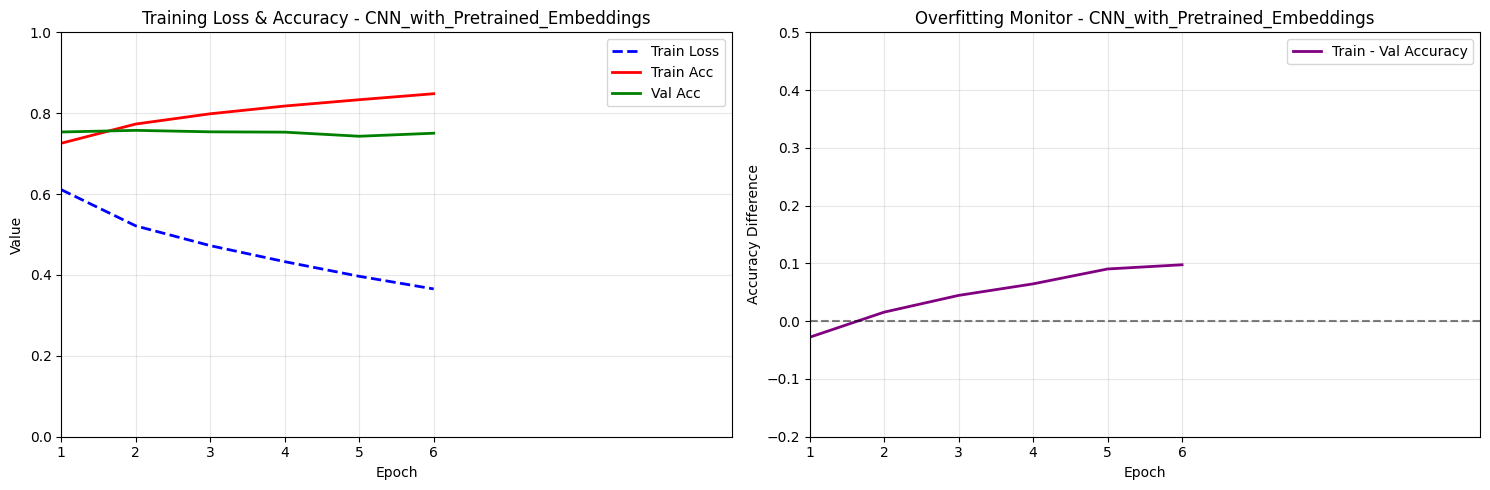


TRAINING SUMMARY
Model Name: CNN_with_Pretrained_Embeddings
Final Train Loss: 0.3655
Final Train Accuracy: 0.8482
Final Val Loss: 0.5973
Final Val Accuracy: 0.7505
Best Val Accuracy: 0.7576 (Epoch 2)
Final Overfitting Gap: 0.0977


In [10]:
# 绘制训练曲线
plot_training_curves("CNN_with_Pretrained_Embeddings", cnn_history)

# 打印训练摘要
print_training_summary("CNN_with_Pretrained_Embeddings", cnn_history)

Testing: 100%|██████████| 58497/58497 [00:58<00:00, 993.50it/s] 



TEST RESULTS
Model Name: CNN with Pretrained Embeddings
Test Accuracy: 0.7485
Test Precision (weighted): 0.7464
Test Recall (weighted): 0.7485
Test F1 Score (weighted): 0.7449

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7997    0.7404    0.7689     18605
     Neutral     0.6635    0.5733    0.6151     14749
    Positive     0.7556    0.8572    0.8032     25143

    accuracy                         0.7485     58497
   macro avg     0.7396    0.7237    0.7291     58497
weighted avg     0.7464    0.7485    0.7449     58497



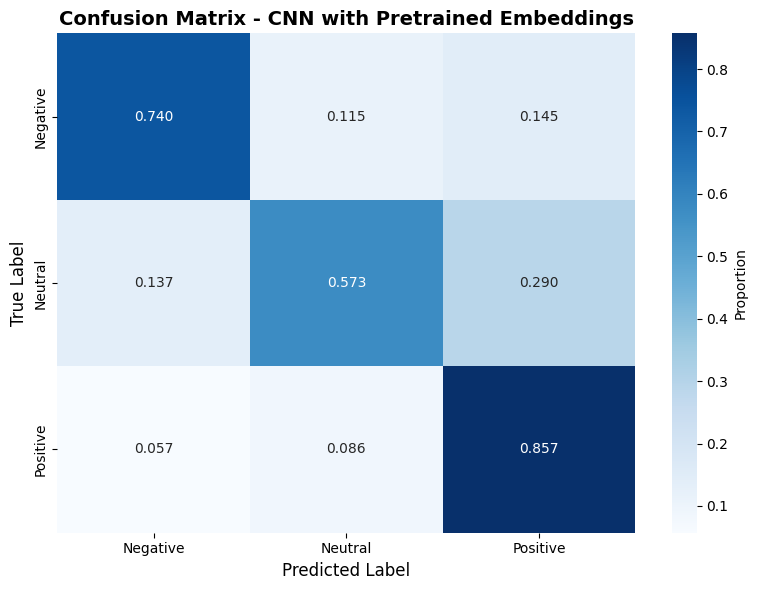


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7997, Recall=0.7404, F1=0.7689, Support=18605
 Neutral: Precision=0.6635, Recall=0.5733, F1=0.6151, Support=14749
Positive: Precision=0.7556, Recall=0.8572, F1=0.8032, Support=25143


In [11]:
# CNN 测试过程 - 使用通用框架
cnn_test_results = test_model_comprehensive(
    model=cnn_pre_emb,
    model_name="CNN with Pretrained Embeddings",
    test_loader=test_data_loader_cnn,
    device=device
)

In [12]:
# 保存CNN训练结果
save_training_results(
    model=cnn_pre_emb,
    model_name="CNN with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(cnn_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=cnn_history,
    test_results=cnn_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: CNN with Pretrained Embeddings (CNN)
  - 实际训练轮数: 6
  - 测试准确率: 0.7485
  - 测试F1分数: 0.7449
  - 记录时间: 2025-11-18 13:54:03
  - 总记录数: 37


### 长短期记忆网络

In [13]:
from MyModule import LSTM, collate_fn_lstm

train_data_loader_lstm = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=True)
val_data_loader_lstm = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=False)
test_data_loader_lstm = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_lstm, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_pre_emb = LSTM(len(vocab), embedding_dim, hidden_dim, num_class, 
                    embedding_matrix.clone().detach(), freeze=False)
lstm_pre_emb.to(device)

LSTM(
  (embeddings): Embedding(35272, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=256, out_features=3, bias=True)
)

In [14]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(lstm_pre_emb.parameters(), lr=0.001)

lstm_history = train_model_with_validation(
    model=lstm_pre_emb,
    train_loader=train_data_loader_lstm,
    val_loader=val_data_loader_lstm,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
    )

Training Epoch 1: 100%|██████████| 8532/8532 [00:56<00:00, 151.82it/s]


Epoch 1/10
    Train Loss: 0.6000	Train Accuracy: 0.7318
    Valid Loss: 0.5446	Valid Accuracy: 0.7541
    Valid Precision: 0.7595	Valid Recall: 0.7541	Valid F1: 0.7512
    ✓ New best validation loss: 0.5446
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8532/8532 [00:55<00:00, 154.32it/s]


Epoch 2/10
    Train Loss: 0.4809	Train Accuracy: 0.7924
    Valid Loss: 0.5273	Valid Accuracy: 0.7639
    Valid Precision: 0.7651	Valid Recall: 0.7639	Valid F1: 0.7603
    ✓ New best validation loss: 0.5273
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8532/8532 [00:55<00:00, 154.46it/s]


Epoch 3/10
    Train Loss: 0.4047	Train Accuracy: 0.8279
    Valid Loss: 0.5428	Valid Accuracy: 0.7644
    Valid Precision: 0.7673	Valid Recall: 0.7644	Valid F1: 0.7634
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8532/8532 [00:55<00:00, 154.71it/s]


Epoch 4/10
    Train Loss: 0.3306	Train Accuracy: 0.8613
    Valid Loss: 0.6051	Valid Accuracy: 0.7661
    Valid Precision: 0.7648	Valid Recall: 0.7661	Valid F1: 0.7645
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8532/8532 [00:55<00:00, 152.98it/s]


Epoch 5/10
    Train Loss: 0.2640	Train Accuracy: 0.8904
    Valid Loss: 0.7124	Valid Accuracy: 0.7610
    Valid Precision: 0.7599	Valid Recall: 0.7610	Valid F1: 0.7602
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5273


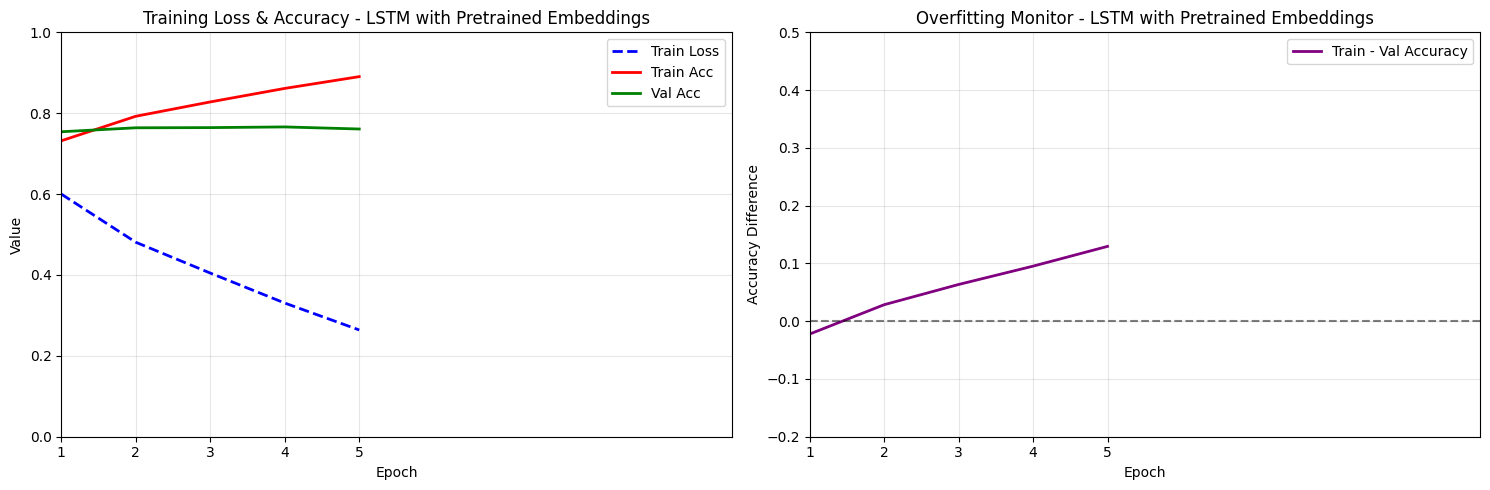


TRAINING SUMMARY
Model Name: LSTM with Pretrained Embeddings
Final Train Loss: 0.2640
Final Train Accuracy: 0.8904
Final Val Loss: 0.7124
Final Val Accuracy: 0.7610
Best Val Accuracy: 0.7661 (Epoch 4)
Final Overfitting Gap: 0.1295


In [15]:
# 绘制训练曲线
plot_training_curves("LSTM with Pretrained Embeddings", lstm_history)

# 打印训练摘要
print_training_summary("LSTM with Pretrained Embeddings", lstm_history)

Testing: 100%|██████████| 58497/58497 [01:16<00:00, 768.45it/s]



TEST RESULTS
Model Name: LSTM with Pretrained Embeddings
Test Accuracy: 0.7605
Test Precision (weighted): 0.7617
Test Recall (weighted): 0.7605
Test F1 Score (weighted): 0.7569

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8355    0.7312    0.7799     18605
     Neutral     0.6868    0.5920    0.6359     14749
    Positive     0.7509    0.8811    0.8108     25143

    accuracy                         0.7605     58497
   macro avg     0.7577    0.7348    0.7422     58497
weighted avg     0.7617    0.7605    0.7569     58497



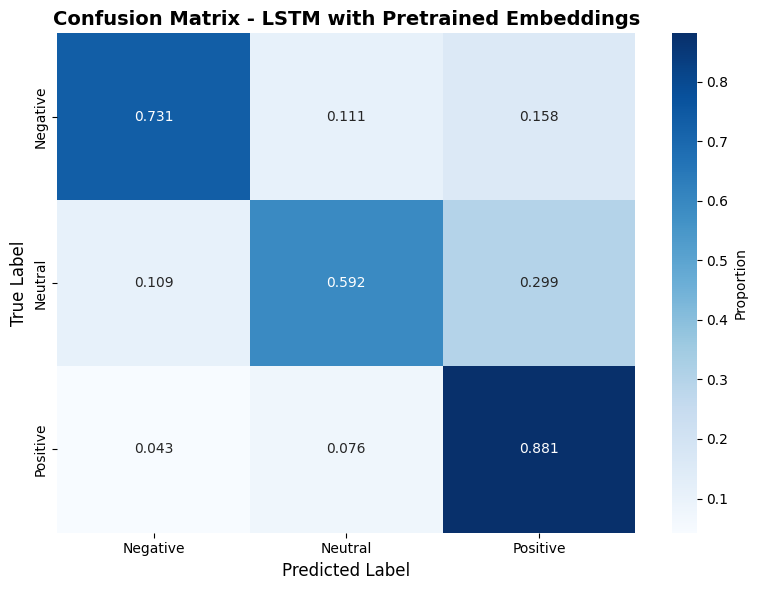


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8355, Recall=0.7312, F1=0.7799, Support=18605
 Neutral: Precision=0.6868, Recall=0.5920, F1=0.6359, Support=14749
Positive: Precision=0.7509, Recall=0.8811, F1=0.8108, Support=25143


In [16]:
# LSTM 测试过程 - 使用通用框架
lstm_test_results = test_model_comprehensive(
    model=lstm_pre_emb,
    model_name="LSTM with Pretrained Embeddings", 
    test_loader=test_data_loader_lstm,
    device=device
)

In [17]:
# 保存LSTM训练结果
save_training_results(
    model=lstm_pre_emb,
    model_name="LSTM with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(lstm_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=lstm_history,
    test_results=lstm_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: LSTM with Pretrained Embeddings (LSTM)
  - 实际训练轮数: 5
  - 测试准确率: 0.7605
  - 测试F1分数: 0.7569
  - 记录时间: 2025-11-18 14:00:23
  - 总记录数: 38


### Transformer

In [18]:
from MyModule import Transformer, collate_fn_trans

train_data_loader_trans = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=True)
val_data_loader_trans = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=False)
test_data_loader_trans = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_trans, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer_pre_emb = Transformer(len(vocab), embedding_dim, num_class, 
                                  pretrained_embedding_matrix=embedding_matrix.clone().detach(), 
                                  freeze=False)
transformer_pre_emb.to(device)

e:\anaconda3\envs\nlpllma\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer(
  (embeddings): Embedding(35272, 200)
  (position_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output): Linear(in_features=200, out_features=3, bias=True)
)

In [19]:

# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(transformer_pre_emb.parameters(), lr=0.001)

transformer_history = train_model_with_validation(
    model=transformer_pre_emb,
    train_loader=train_data_loader_trans,
    val_loader=val_data_loader_trans,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 8532/8532 [01:01<00:00, 139.38it/s]


Epoch 1/10
    Train Loss: 0.7546	Train Accuracy: 0.6526
    Valid Loss: 0.6923	Valid Accuracy: 0.6857
    Valid Precision: 0.6844	Valid Recall: 0.6857	Valid F1: 0.6756
    ✓ New best validation loss: 0.6923
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8532/8532 [01:01<00:00, 139.57it/s]


Epoch 2/10
    Train Loss: 0.7184	Train Accuracy: 0.6751
    Valid Loss: 0.6998	Valid Accuracy: 0.6827
    Valid Precision: 0.6876	Valid Recall: 0.6827	Valid F1: 0.6772
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8532/8532 [01:01<00:00, 139.63it/s]


Epoch 3/10
    Train Loss: 0.7032	Train Accuracy: 0.6887
    Valid Loss: 0.7132	Valid Accuracy: 0.6900
    Valid Precision: 0.6866	Valid Recall: 0.6900	Valid F1: 0.6863
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8532/8532 [01:01<00:00, 139.82it/s]


Epoch 4/10
    Train Loss: 0.6825	Train Accuracy: 0.6957
    Valid Loss: 0.6790	Valid Accuracy: 0.6931
    Valid Precision: 0.6947	Valid Recall: 0.6931	Valid F1: 0.6834
    ✓ New best validation loss: 0.6790
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8532/8532 [01:01<00:00, 139.74it/s]


Epoch 5/10
    Train Loss: 0.6575	Train Accuracy: 0.7092
    Valid Loss: 0.6785	Valid Accuracy: 0.7063
    Valid Precision: 0.7021	Valid Recall: 0.7063	Valid F1: 0.7011
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 8532/8532 [01:01<00:00, 139.79it/s]


Epoch 6/10
    Train Loss: 0.6512	Train Accuracy: 0.7153
    Valid Loss: 0.7030	Valid Accuracy: 0.6947
    Valid Precision: 0.6947	Valid Recall: 0.6947	Valid F1: 0.6942
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 8532/8532 [01:01<00:00, 139.08it/s]


Epoch 7/10
    Train Loss: 0.6530	Train Accuracy: 0.7132
    Valid Loss: 0.6873	Valid Accuracy: 0.7060
    Valid Precision: 0.7026	Valid Recall: 0.7060	Valid F1: 0.7009
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.6790


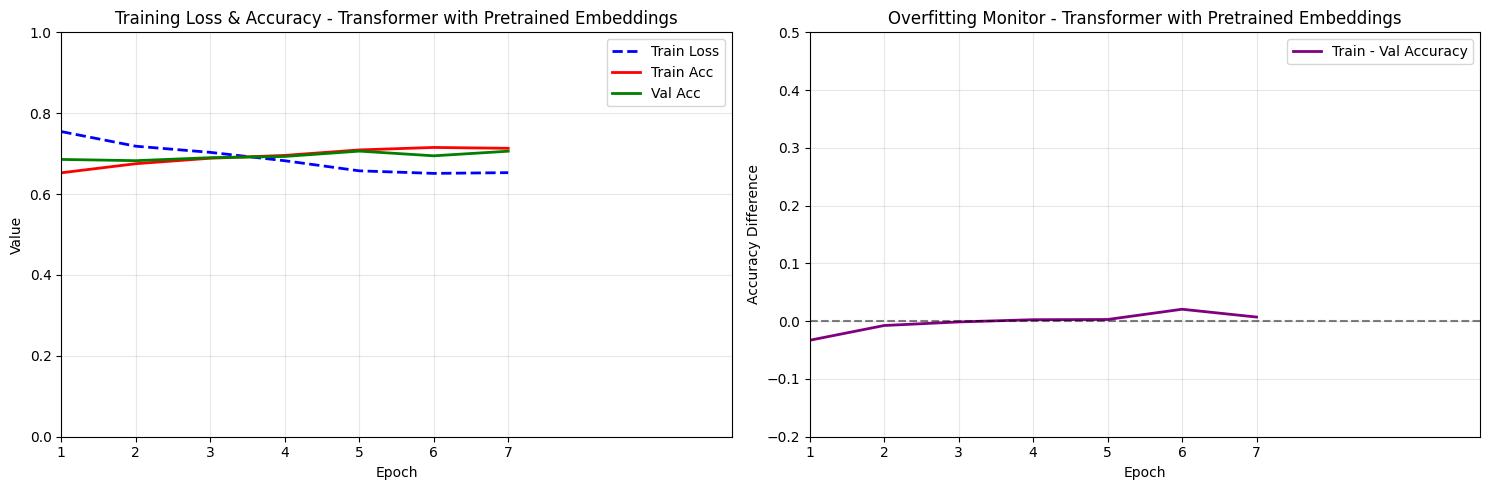


TRAINING SUMMARY
Model Name: Transformer with Pretrained Embeddings with Pretrained Embeddings
Final Train Loss: 0.6530
Final Train Accuracy: 0.7132
Final Val Loss: 0.6873
Final Val Accuracy: 0.7060
Best Val Accuracy: 0.7063 (Epoch 5)
Final Overfitting Gap: 0.0071


In [20]:
# 绘制训练曲线
plot_training_curves("Transformer with Pretrained Embeddings", transformer_history)

# 打印训练摘要
print_training_summary("Transformer with Pretrained Embeddings with Pretrained Embeddings", transformer_history)

Testing: 100%|██████████| 58497/58497 [01:54<00:00, 512.85it/s]



TEST RESULTS
Model Name: Transformer with Pretrained Embeddings
Test Accuracy: 0.6932
Test Precision (weighted): 0.6940
Test Recall (weighted): 0.6932
Test F1 Score (weighted): 0.6833

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7343    0.6750    0.7034     18605
     Neutral     0.6698    0.4454    0.5350     14749
    Positive     0.6783    0.8521    0.7553     25143

    accuracy                         0.6932     58497
   macro avg     0.6941    0.6575    0.6646     58497
weighted avg     0.6940    0.6932    0.6833     58497



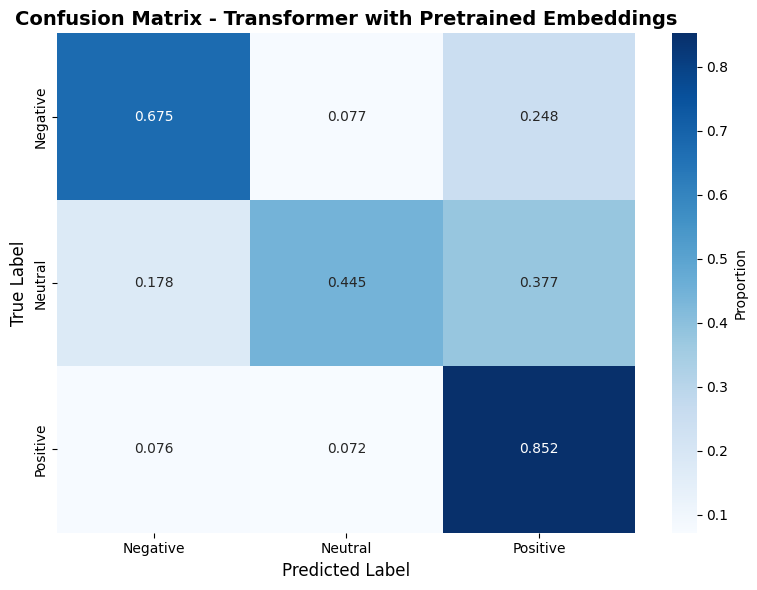


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7343, Recall=0.6750, F1=0.7034, Support=18605
 Neutral: Precision=0.6698, Recall=0.4454, F1=0.5350, Support=14749
Positive: Precision=0.6783, Recall=0.8521, F1=0.7553, Support=25143


In [21]:
# Transformer 测试过程 - 使用通用框架
transformer_test_results = test_model_comprehensive(
    model=transformer_pre_emb,
    model_name="Transformer with Pretrained Embeddings",
    test_loader=test_data_loader_trans,
    device=device
)

In [22]:
# 保存Transformer训练结果
save_training_results(
    model=transformer_pre_emb,
    model_name="Transformer with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(transformer_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=transformer_history,
    test_results=transformer_test_results,
)

✓ 训练结果已保存到 results/model_training_results.json
  - 模型: Transformer with Pretrained Embeddings (Transformer)
  - 实际训练轮数: 7
  - 测试准确率: 0.6932
  - 测试F1分数: 0.6833
  - 记录时间: 2025-11-18 14:10:07
  - 总记录数: 39
